In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np
import itertools

In [2]:
# load my cleaned and post_processed version of Tweets.csv
tweets = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

# What kinds of words are most common in this dataset? 

### Wordclouds

In [3]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
twt = TweetTokenizer()
def at_mentions_tokenize(text_series): 
    '''
    get only @ mentions
    '''
    at_tokenizer = RegexpTokenizer("@\w+")
    return text_series.map(lambda t: at_tokenizer.tokenize(t))

In [4]:
at_tokenized = at_mentions_tokenize(tweets.text_orig)
all_mentions_str = ' '.join([' '.join(at_tokenized.values[i]) for i in range(at_tokenized.shape[0])])
all_mentions_str = re.sub(r"@", "", all_mentions_str)

The @mentions in this dataset are, unsurprisingly, largely airlines

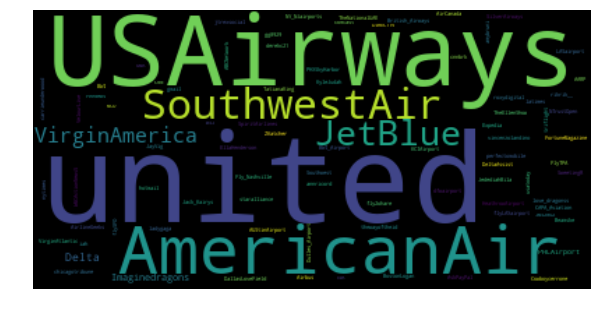

<Figure size 432x288 with 0 Axes>

In [5]:
from wordcloud import WordCloud
at_cloud = WordCloud(collocations=False).generate(all_mentions_str)
plt.figure(figsize=(10,10) )
plt.imshow(at_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('plts/at_mention_cloud.png')

Now let's take a look at other words that are common in this corpus. We've specifically removed @mentions here. 

The most frequent words in this corpus aren't a surprise: they pertain to flying, as do (hopefully) most of the tweets. 

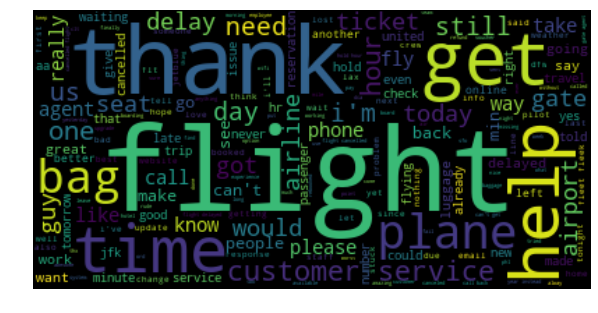

<Figure size 432x288 with 0 Axes>

In [6]:
at_and_text_tokenizer = TweetTokenizer(preserve_case = False, strip_handles = True)
removed_links = tweets.text_orig.str.replace(r'http\S+', '')
at_and_texted = removed_links.map(lambda t: at_and_text_tokenizer.tokenize(t))
all_tweet_str = ' '.join([' '.join(at_and_texted.values[i]) for i in range(at_and_texted.shape[0])])
all_tweet_str = re.sub(r"@\w+", "", all_tweet_str)
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))
text_cloud = WordCloud(stopwords=stopwords).generate(all_tweet_str)
plt.figure(figsize=(10,10) )
plt.imshow(text_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('plts/word_wordcloud.png')

# What are the characteristics of our corpus?

What sorts of words are in our corpus? What are the most frequent words?

In [14]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
stopwords = set(stopwords.words('english'))
punctuation_set = set([i for i in string.punctuation])
stopwords = stopwords.union(punctuation_set)
tokenizer = TweetTokenizer(preserve_case= False)

tweet_text =tweets.text_clean.map(tokenizer.tokenize)
tweet_text 

# Remove stopwords
tweet_text = tweet_text.map(lambda tokenized_tweet: [word for word in tokenized_tweet if word not in stopwords])

# Calculate frequency distribution
words = [word for tweet in tweet_text.values for word in tweet] # flatten list of lists 
fdist = FreqDist(words)

# Output top 20 words

for word, frequency in fdist.most_common(50):
    print(u'{};{}'.format(word, frequency))

united;3982
flight;3352
usairways;2948
americanair;2704
southwestair;2382
jetblue;2103
get;1331
thanks;1055
service;952
help;838
hours;771
time;769
customer;741
i'm;681
us;668
hold;635
plane;625
flights;614
thank;600
still;579
please;561
one;558
need;552
would;545
cancelled;532
can't;530
delayed;528
back;517
gate;510
call;505
virginamerica;495
bag;489
hour;472
got;458
phone;425
like;423
today;415
airline;393
fly;377
guys;374
waiting;365
know;353
trying;345
u;344
airport;340
way;339
great;332
day;327
never;318
going;317


In [12]:
len(fdist)

15131

There are 15,131 words in our corpus. We notice airline names show up quite frequently: this is an artifact of the way that these tweets were collected (@mentions). Many of the frequent words are ones we'd expect such as "airline", "fly", and "waiting". We also see the shortening "u". It's unsurprising that this is common in a corpus based on tweets. 

# Types and frequency of emojis. 

Recent research projects such as [DeepMoji](https://deepmoji.mit.edu/) try to leverage emojis for tasks such as sentiment analysis. There's a significant difference in meaning between "Let's see 🙂" and "Let's see 🙄". The difference can only be captured if we consider the emojis. 

In [15]:
import emoji
from collections import defaultdict

unicode_emojis = emoji.UNICODE_EMOJI.keys()
emoji_freq = defaultdict(int)
for tweet in tweet_text.values: 
    for word in tweet: 
        if word in unicode_emojis: 
            emoji_freq[word]+=1
emoji_df = pd.DataFrame.from_dict(emoji_freq, orient='index')

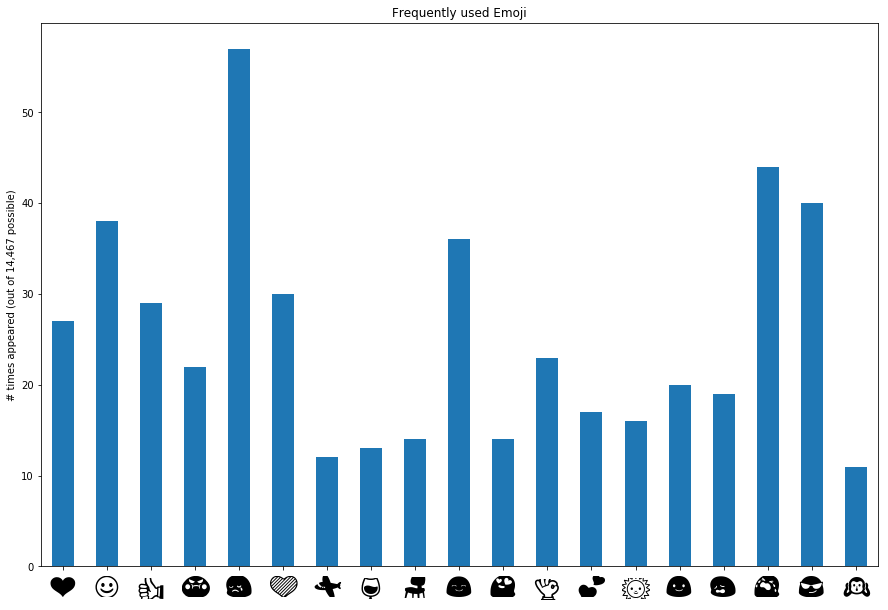

In [19]:
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoEmoji-Regular.ttf')  # specify font
ax = emoji_df[0].where(emoji_df[0]>10).dropna().plot(kind='bar', figsize=(15,10))
_ = ax.set_xticklabels(emoji_df.index, fontproperties=font, rotation=0, fontsize=25)
_ = plt.title('Frequently used Emoji')
_ = plt.ylabel('# times appeared (out of 14,467 possible)')

In [21]:
sum(emoji_freq.values())

786

Out of a total of 14,467 tweets in our sample, we find that emojis were used 786 times. That's not a lot: it's possible that whoever compiled this dataset before deliberately selected tweets with fewer emojis. We unfortunately don't know. 

# Tweet length 

How long is the average tweet?

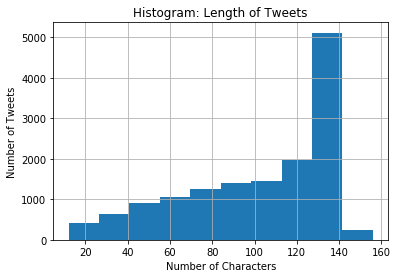

In [3]:
tweet_len_ser = tweets.text_orig.apply(len)

_ = tweet_len_ser.hist()
_ = plt.title('Histogram: Length of Tweets')
_ = plt.xlabel('Number of Characters')
_ = plt.ylabel('Number of Tweets')

Looking at the uncleaned text, we see that a nontrivial amount of tweets have more than 140 characters: this turned out to be a parsing issue. After postprocessing, we were still left with some tweets that have 141 characters. 

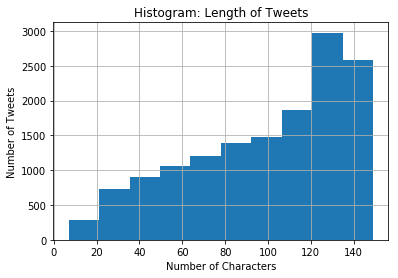

In [4]:
tweet_len_ser = tweets.text_clean.apply(len)

_ = tweet_len_ser.hist()
_ = plt.title('Histogram: Length of Tweets')
_ = plt.xlabel('Number of Characters')
_ = plt.ylabel('Number of Tweets')

In [6]:
tweet_len_ser.describe()

count    14467.000000
mean        98.633995
std         35.815096
min          7.000000
25%         71.000000
50%        108.000000
75%        131.000000
max        149.000000
Name: text_clean, dtype: float64

The average tweet is about 98 characters long, and the median tweet is about 108 characters long. That suggests that some tweets are very short, which seems reasonable. Tweets can be really short. 

# Hashtags and @mentions 

Hashtags and mentions are present in this dataset. How often are they used, and who usually gets mentioned?

In [9]:
tweet_text_wat =tweets.text_orig.map(tokenizer.tokenize)

# Remove stopwords
tweet_text_wat = tweet_text_wat.map(lambda tokenized_tweet: [word for word in tokenized_tweet if word not in stopwords])

# Calculate frequency distribution
words = [word for tweet in tweet_text_wat.values for word in tweet] # flatten list of lists 
fdist_with_ats_hashtags = FreqDist(words)

In [10]:
hashtag_freq = {key:value for key, value in fdist_with_ats_hashtags.items() if key[0] == '#'}
hashtag_df = pd.DataFrame.from_dict(hashtag_freq, orient='index')
mention_freq = {key:value for key, value in fdist_with_ats_hashtags.items() if key[0]=='@'}
mention_df = pd.DataFrame.from_dict(mention_freq, orient='index')

In [11]:
mention_df[0].sort_values(ascending=False)[:10]

@united            3893
@usairways         2993
@americanair       2787
@southwestair      2458
@jetblue           2247
@virginamerica      518
@delta               65
@imaginedragons      45
@phlairport          20
@dfwairport          16
Name: 0, dtype: int64

Unsurprisingly, airlines are at the top of the list of @ mentions. We also see some airports. 

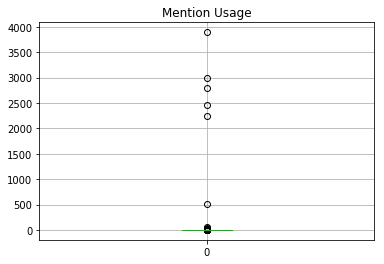

In [15]:
_ = mention_df.boxplot()
_ = plt.title('Mention Usage')

In [13]:
hashtag_df[0].sort_values(ascending=False)[:10]

#destinationdragons    81
#fail                  68
#jetblue               48
#unitedairlines        45
#customerservice       36
#usairways             29
#neveragain            27
#usairwaysfail         26
#americanairlines      26
#united                26
Name: 0, dtype: int64

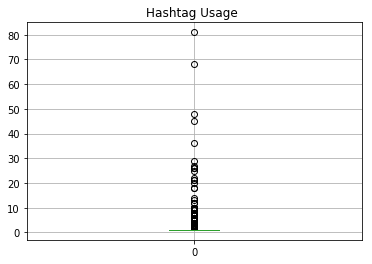

In [14]:
_ = hashtag_df.boxplot()
_ = plt.title('Hashtag Usage ')

Hashtags are a little bit more interesting: the presence of #fail, for example, is a pretty good indication that the airline sentiment is probably negative. 

# Sentiment

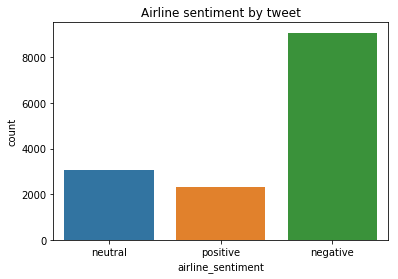

In [18]:
_ = sns.countplot(tweets.airline_sentiment)
_ = plt.title('Airline sentiment by tweet')

In [19]:
tweets.airline_sentiment.value_counts()

negative    9081
neutral     3060
positive    2326
Name: airline_sentiment, dtype: int64

In [20]:
9081/tweets.shape[0]

0.6277044307734845